## <span style="color: Navy"> Table des matières </span> 
##### 1.[Introduction](#.-Introduction)

##### 2.[Collecte des données](#.-Collecte_des_données)

##### 3.[Prétraitement](#.-Prétraitement)

##### 4.[Construction du modèle](#.-Construction_du_modèle)

##### 5.[Evaluation du modèle ](#.-Evaluation_du_modèle)



## <p style='text-align: center;'> Analyse des sentiments Tweets 😀😢 avec NuSVC CNB MNB RL AdaBoost </p> 

## <span style="color: Navy"> 1.Intorduction </span> 

<div style="text-align:center;">
<img src="images/Le flux de travail général de l'analyse des sentiments.png" alt="Analyse des sentiments: Processus" width="400" height="200">
</div>

***

 ## <span style="color:Navy"> 2. Collecte des données </span>

****

<span style="color: DimGray"> **1.1 Importation des bibliothèques**  </span>

In [77]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

<span Style="color: DimGray"> **1.2 Importation des données**</span> 

In [3]:
colonnes= ['ids', 'Target', 'text']
df1 = pd.read_csv('Datasets\Sentiment140-MV-Train.csv',names=colonnes)
df2=pd.read_csv('Datasets\Sentiment140-MV-Test.csv',names=colonnes)
df = pd.concat([df1, df2], ignore_index=True)

In [5]:
df.head()

,ids,Target,text
0,1834873030,1,USER_MENTION oh that sounds yummy we dont have...
1,2062647136,0,USER_MENTION theres so many fakes of you
2,2013029024,1,USER_MENTION um nothing new apart from street ...
3,2184368404,1,USER_MENTION USER_MENTION the day cnn started ...
4,2214865531,0,missing my dad my brother today


<span style="color:DimGray"> **1.3 exploration des données**</span>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     19995 non-null  int64 
 1   Target  19995 non-null  int64 
 2   text    19995 non-null  object
dtypes: int64(2), object(1)
memory usage: 468.8+ KB


In [7]:
df.isnull().sum()

ids       0
Target    0
text      0
dtype: int64

In [8]:
df.duplicated().sum()

1782

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df['Target'].value_counts()

Target
1    11628
0     6585
Name: count, dtype: int64

## <span style="color:Navy"> 3. Prétraitement</span>

***

<span style="color:DimGray"> **3.1 Suppression des colonnes non-utiles** </span>

 <span style="color: DimGray"> **3.2 Covertion de Target 4 à 1**  </span> 

<span style="color: DimGray"> **3.3 Visualisation des données ( La distribution des classes)** </span> 

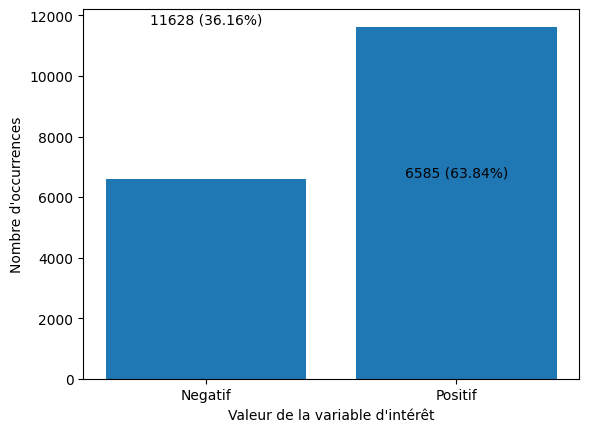

In [11]:
target_counts = df['Target'].value_counts()

# Calcul du proportion pour chaque valeur de la variable d'intérêt (Target)
target_proportions = df['Target'].value_counts(normalize=True)

# Création d'un graphique à barres pour visualiser la distribution
plt.bar(target_counts.index, target_counts.values)

# Ajoute des étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(target_counts):
    proportion = target_proportions[i]
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

# Étiquetage de l'axe des x et y
plt.xlabel('Valeur de la variable d\'intérêt')
plt.ylabel('Nombre d\'occurrences')

# Ajoute d'une légende aux barres
plt.xticks(target_counts.index, ['Positif', 'Negatif'])

# Affichage du graphique
plt.show()

<span style="color:DimGray"> **3.4 Racinisation** </span> 

In [12]:
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [13]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [15]:
def lemmitizer(content):
    # Suppression des caractères non alphabétiques
    texte_nettoye = re.sub('[^a-zA-Z]', ' ', content)
    # Suppression des adresses URL
    content = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', content)
    content = content.lower()
    # Tokenization
    tokens = content.split()
    # Lemmatisation et suppression des mots vides
    lemmitized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    # Reconstruction du texte
    lemmitized_text = ' '.join(lemmitized_tokens)
    return lemmitized_text


# On applique le nettoyage du texte sur la colonne 'texte'
df['texte_nettoye'] = df['text'].apply(lemmitizer)

In [16]:
df.head()

,ids,Target,text,texte_nettoye
0,1834873030,1,USER_MENTION oh that sounds yummy we dont have...,user_mention sound yummy dont bloomingdales th...
1,2062647136,0,USER_MENTION theres so many fakes of you,user_mention there many fake
2,2013029024,1,USER_MENTION um nothing new apart from street ...,user_mention nothing new apart street fighter
3,2184368404,1,USER_MENTION USER_MENTION the day cnn started ...,user_mention user_mention day cnn started sour...
4,2214865531,0,missing my dad my brother today,missing dad brother today


<span style='color:DimGray'> **3.5 Visualisation** </spand>

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

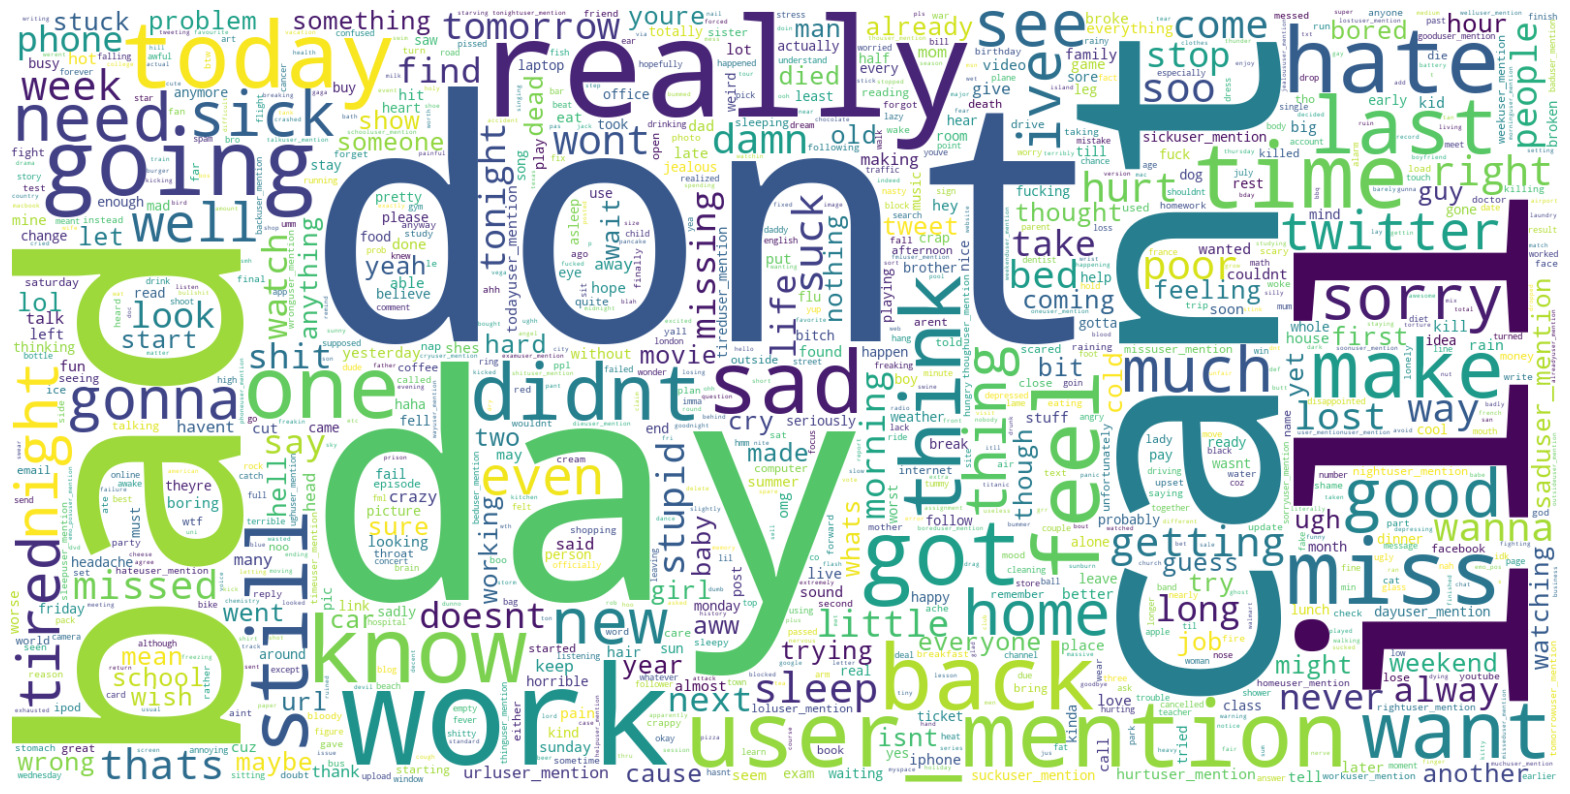

In [18]:
#filtrage des tweets Negatif 
data_neg= df[df['Target'] == 0]['texte_nettoye']

#Création d'un nuage de mots  
wc = WordCloud(max_words = 1000, width=1600, height = 800, collocations= False, background_color='white').generate("".join(data_neg))

#affichage 
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

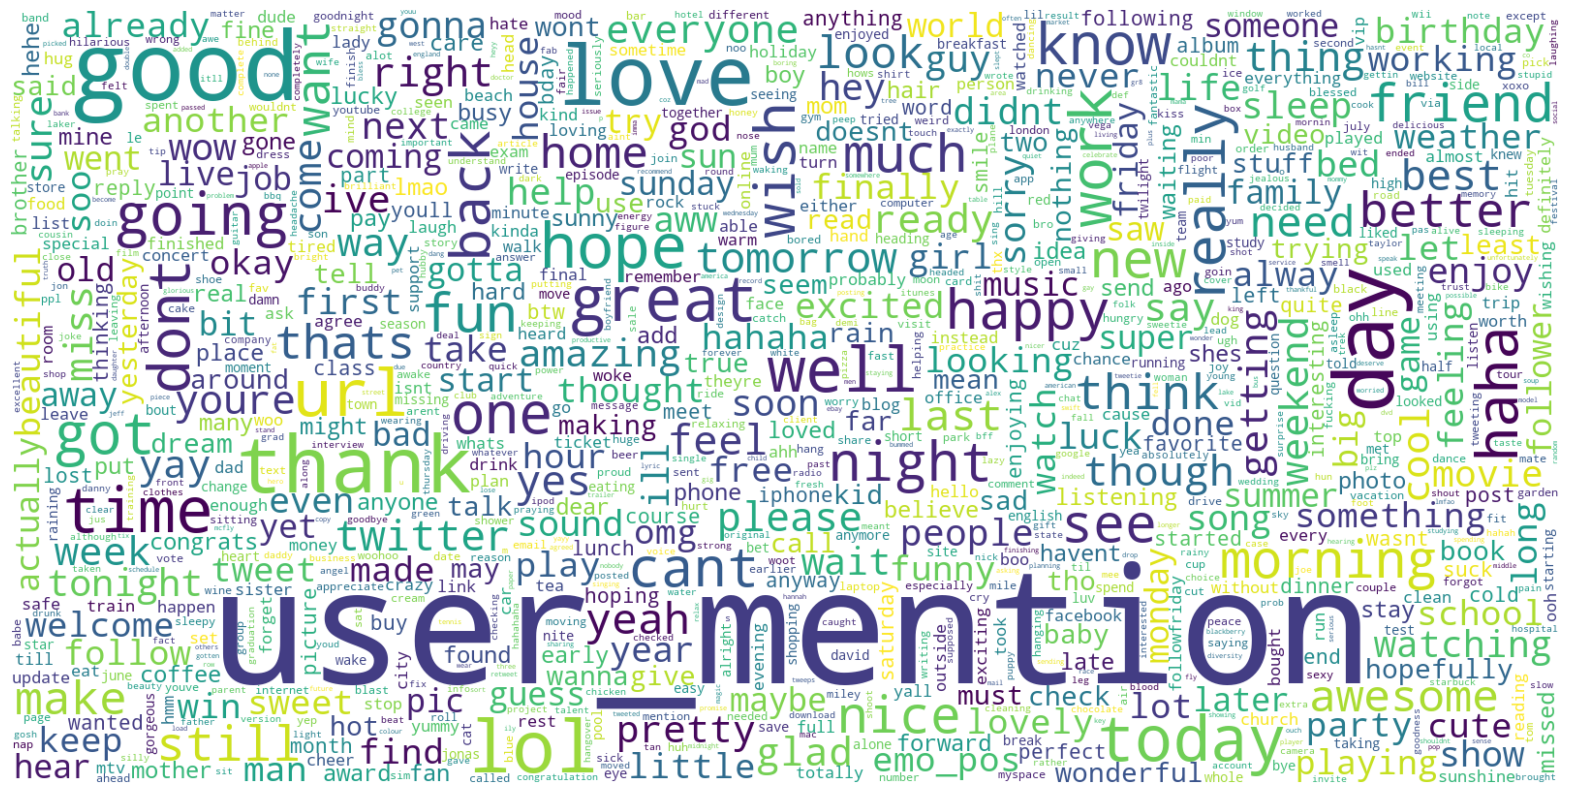

In [19]:
#filtrage des tweets posifit
data_neg = df[df['Target'] == 1]['texte_nettoye']

# Créer un nuage de mots à partir des données négatives
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False, background_color='white').generate(" ".join(data_neg))

# Afficher le nuage de mots
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<span style='color:DimGray'> **3.6 Modélisation** </spand>

* Séparation des données

In [20]:
X=df['texte_nettoye'].values
Y=df['Target'].values

**X:** Représente la variable indépendante

**Y:** Représente la variable dépendante

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

<span style='color:DimGray'> **3.7 Convertion du texte en numérique** </spand>

In [22]:
vectorizer= TfidfVectorizer()
X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

 ## <span style='color:Navy'> 4.Construction des modèles </span>

****

<span style='color:DimGray'>  **Construction du modèle** </span> 

#### Multinomial naive bayes model

In [79]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

MultinomialNB()

#### Complement Naive bayes model:

In [78]:
from sklearn.naive_bayes import ComplementNB
CNB = ComplementNB()
CNB.fit(X_train, y_train)

ComplementNB()

### Adaboost 

In [74]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoost = AdaBoostClassifier(n_estimators=60, random_state=42,learning_rate=1)
AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=60, random_state=42)

### Regression Logistique 

In [84]:
RegressionLogistique =LogisticRegression(max_iter=1000)
RegressionLogistique.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

### NuSVC

In [90]:
from sklearn.svm import NuSVC
NuSVC = NuSVC(nu=0.5, kernel='rbf', random_state=42)
NuSVC.fit(X_train, y_train)

NuSVC(random_state=42)

## <span style='color:Navy'> 5.Evaluation des modèles </span>

****

<span style='color:DimGray'> **5.1 Matrice de confusion et Rapport de classification** </span>

### Multinomial NB

In [76]:
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('accuracy : ',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Matrice de confusion:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Rapport de classification:')
print(classification_report(y_test, predicted))

accuracy :  78.23%
------------------------------------------------
Matrice de confusion:
     0     1
0  566   751
1   42  2284
------------------------------------------------
Rapport de classification:
              precision    recall  f1-score   support

           0       0.93      0.43      0.59      1317
           1       0.75      0.98      0.85      2326

    accuracy                           0.78      3643
   macro avg       0.84      0.71      0.72      3643
weighted avg       0.82      0.78      0.76      3643



### Complement NB

In [80]:
predicted = CNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('accuracy: ',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Matrice de confusion:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------')
print('Rapport de classification')
print(classification_report(y_test, predicted))

accuracy:  85.20%
------------------------------------------------
Matrice de confusion:
     0     1
0  962   355
1  184  2142
------------------------
Rapport de classification
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1317
           1       0.86      0.92      0.89      2326

    accuracy                           0.85      3643
   macro avg       0.85      0.83      0.83      3643
weighted avg       0.85      0.85      0.85      3643



### AdaBoost

In [112]:
predicted = AdaBoost.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('accuracy: ',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Matrice de confusion:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------')
print('Rapport de classification')
print(classification_report(y_test, predicted))

accuracy:  80.46%
------------------------------------------------
Matrice de confusion:
      0     1
0  1005   312
1   400  1926
------------------------
Rapport de classification
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1317
           1       0.86      0.83      0.84      2326

    accuracy                           0.80      3643
   macro avg       0.79      0.80      0.79      3643
weighted avg       0.81      0.80      0.81      3643



### Regression logistique 

In [85]:
predicted = RegressionLogistique.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('accuracy: ',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Matrice de confusion:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------')
print('Rapport de classification')
print(classification_report(y_test, predicted))

accuracy:  87.54%
------------------------------------------------
Matrice de confusion:
     0     1
0  991   326
1  128  2198
------------------------
Rapport de classification
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1317
           1       0.87      0.94      0.91      2326

    accuracy                           0.88      3643
   macro avg       0.88      0.85      0.86      3643
weighted avg       0.88      0.88      0.87      3643



### NuSVC

In [91]:
predicted = NuSVC.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('accuracy: ',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Matrice de confusion:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------')
print('Rapport de classification')
print(classification_report(y_test, predicted))

accuracy:  87.84%
------------------------------------------------
Matrice de confusion:
     0     1
0  995   322
1  121  2205
------------------------
Rapport de classification
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1317
           1       0.87      0.95      0.91      2326

    accuracy                           0.88      3643
   macro avg       0.88      0.85      0.86      3643
weighted avg       0.88      0.88      0.88      3643



### Comparaison des modèles 

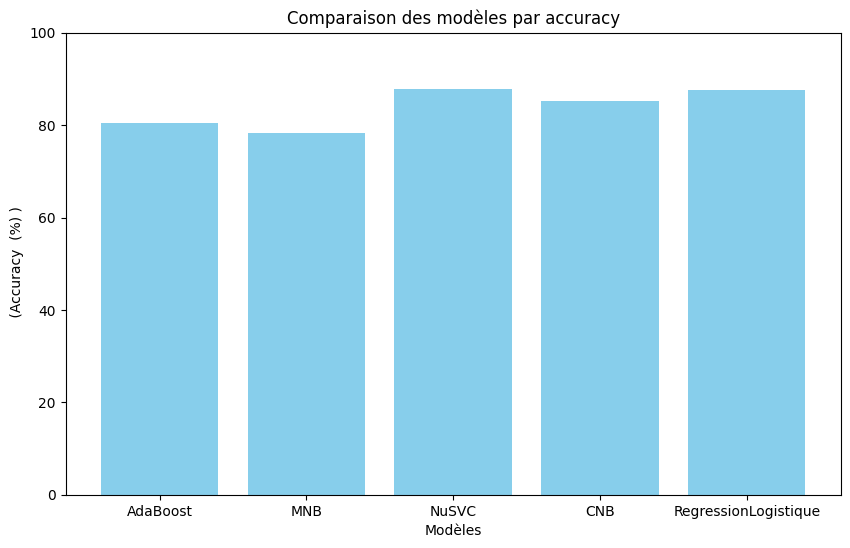

In [107]:
accuracies = [80.46, 78.23, 87.84,85.20, 87.54 ]  
model_names = ['AdaBoost', 'MNB', 'NuSVC', 'CNB', 'RegressionLogistique']  # Noms des modèles

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Modèles')
plt.ylabel(' (Accuracy  (%) )')
plt.title('Comparaison des modèles par accuracy')
plt.ylim(0, 100)  # Plage de l'axe y de 0 à 100
plt.show()
    
    

## <span style='color:Navy'> Prédiction  </span>

****

* Positif

In [71]:
# Text
text = "I'm happy!"

# Appliquer la fonction de racinisation à la nouvelle observation
lemmatized_new_text = lemmitizer(text)

#Conversion du text
vectorized_new_text = vectorizer.transform([lemmatized_new_text])

# Prédiction
# en change CNB par MNB AdaBoost pour les autres modèles modèle
prediction = CNB.predict(vectorized_new_text)

# Affichage des résultats
if prediction == 0:
    print("Sentiment est: négatif 😢.")
else:
    print("Sentiment est:  positif 😀.")

Sentiment est:  positif 😀.


* Négatif

In [82]:
# Text
text = "It's a sad day!"

# On applique la fonction de racinisation à la nouvelle observation
lemmatized_new_text = lemmitizer(text)

#Conversion du text
vectorized_new_text = vectorizer.transform([lemmatized_new_text])

# Prédiction
# en change CNB par MNB AdaBoost pour les autres modèles modèle
prediction = CNB.predict(vectorized_new_text)

# Affichage des résultats
if prediction == 0:
    print("Sentiment est: négatif 😢.")
else:
    print("Sentiment est:  positif 😀 .")

Sentiment est: négatif 😢.
